In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import pcntoolkit as ptk
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from pcntoolkit.util.utils import calibration_descriptives
from pcntoolkit.model.hbr import bspline_fit, bspline_transform
from sklearn.preprocessing import OneHotEncoder

In [2]:
projdir = '/project_cephfs/3022017.02/projects/stijdboe/make_results/more_flexible_models_lifespan_big/'
textfiles = os.path.join(projdir,'textfiles')
if not os.path.exists(textfiles):
    os.mkdir(textfiles)
data_dir = '/project_cephfs/3022017.02/projects/stijdboe/Data/UMAP_data'


### Fit the models

Now we fit the models. This involves looping over the IDPs we have selected. We will use a module from PCNtoolkit to set up the design matrices, containing the covariates, fixed effects for site and nonlinear basis expansion. 

In [5]:
warp =  'WarpSinArcsinh'
# For each fold

this_identifier = f"blr_UMAP"
processing_dir = os.path.join(projdir, this_identifier+'/')
if not os.path.exists(processing_dir):
    os.mkdir(processing_dir)

log_dir = os.path.join(processing_dir, 'log')           #
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

# The paths to the data
X_tr_path = os.path.join(data_dir, 'cov_tr.txt')
Y_tr_path = os.path.join(data_dir, 'trainselect.txt')

X_te_path = os.path.join(data_dir, 'cov_te.txt')
Y_te_path = os.path.join(data_dir, 'testselect.txt')

X_tr = np.loadtxt(X_tr_path)
X_te = np.loadtxt(X_te_path)


Phi_tr = create_design_matrix(X_tr, basis='bspline')
Phi_te = create_design_matrix(X_te, basis='bspline')

# Save as text files 
Phi_tr_path = os.path.join(textfiles, f'Phi_tr.txt' )
Phi_te_path = os.path.join(textfiles, f'Phi_te.txt' )
np.savetxt(Phi_tr_path, Phi_tr)
np.savetxt(Phi_te_path, Phi_te)

Y_tr = np.loadtxt(Y_tr_path)
Y_te = np.loadtxt(Y_te_path)


os.chdir(processing_dir)

F_tr = Y_tr
F_tr_mean  = F_tr.mean(axis = 0)
F_tr_std = F_tr.std(axis= 0)
F_tr = (F_tr - F_tr_mean)/F_tr_std
F_te = Y_te
F_te = (F_te - F_tr_mean)/F_tr_std

# Save as text files 
Y_feature_tr_path = os.path.join(textfiles, f'Y_UMAP_tr.txt' )
Y_feature_te_path = os.path.join(textfiles, f'Y_UMAP_te.txt' )
np.savetxt(Y_feature_tr_path, F_tr)
np.savetxt(Y_feature_te_path, F_te)

# Fit the model
estimate(
         Phi_tr_path,  
         Y_feature_tr_path,
         testcov=Phi_te_path, 
         testresp=Y_feature_te_path, 
         alg='blr', optimizer = 'powell', 
         savemodel=True, warp=warp, warp_reparam=True)



Processing data in /project_cephfs/3022017.02/projects/stijdboe/make_results/more_flexible_models_lifespan_big/textfiles/Y_UMAP_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: 15322.752023
         Iterations: 5
         Function evaluations: 249
Saving model meta-data...
Evaluating the model ...
Writing outputs ...


In [ ]:

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
   
    # set output dir 
    idp_dir = os.path.join(out_dir, idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)
    
    # extract the response variables for training and test set
    y_tr = df_tr[idp].to_numpy() 
    y_te = df_te[idp].to_numpy()
    
    # remove gross outliers and implausible values
    yz_tr = (y_tr - np.mean(y_tr)) / np.std(y_tr)
    yz_te = (y_te - np.mean(y_te)) / np.std(y_te)
    nz_tr = np.bitwise_and(np.abs(yz_tr) < outlier_thresh, y_tr > 0)
    nz_te = np.bitwise_and(np.abs(yz_te) < outlier_thresh, y_te > 0)
    y_tr = y_tr[nz_tr]
    y_te = y_te[nz_te]
    
    # write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)
        
    # configure the design matrix
    X_tr = create_design_matrix(df_tr[cols_cov].loc[nz_tr], 
                                site_ids = df_tr['site'].loc[nz_tr],
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    X_te = create_design_matrix(df_te[cols_cov].loc[nz_te], 
                                site_ids = df_te['site'].loc[nz_te], 
                                all_sites=site_ids,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)

    # configure and save the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)

    if not force_refit and os.path.exists(os.path.join(idp_dir, 'Models', 'NM_0_0_estimate.pkl')):
        print('Making predictions using a pre-existing model...')
        suffix = 'predict'
        
        # Make prdictsion with test data
        predict(cov_file_te, 
                alg='blr', 
                respfile=resp_file_te, 
                model_path=os.path.join(idp_dir,'Models'),
                outputsuffix=suffix)
    else:
        print('Estimating the normative model...')
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
                 testcov=cov_file_te, alg='blr', optimizer = 'l-bfgs-b', 
                 savemodel=True, warp=warp, warp_reparam=True)
        suffix = 'estimate'

### Compute error metrics

In this section we compute the following error metrics for all IDPs (all evaluated on the test set):

- Negative log likelihood (NLL)
- Explained variance (EV)
- Mean standardized log loss (MSLL)
- Bayesian information Criteria (BIC)
- Skew and Kurtosis of the Z-distribution

In [ ]:
# initialise dataframe we will use to store quantitative metrics 
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)
    
    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
    
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  
        
        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp
        
        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
       
        # evaluation metrics
        metrics = evaluate(y_te, med_te)
        
        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     
    
    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
    
    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
    
    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], BIC, skew, kurtosis]
    
display(blr_metrics)

blr_metrics.to_csv(os.path.join(out_dir,'blr_metrics.csv'))

In [ ]:
blr_metrics['EV'].describe()

In [ ]:
blr_metrics['MSLL'].describe()

In [ ]:
blr_metrics['EV'].hist()

In [30]:
blr_metrics['MSLL'].hist()

NameError: name 'blr_metrics' is not defined

[ 0.50599119  0.48022354 -0.60510183 ...  0.96262702  0.4069762
  0.7939674 ]


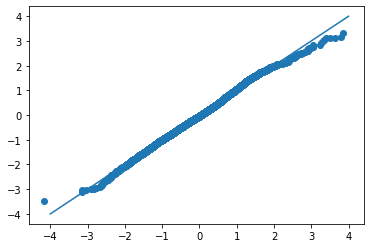

In [42]:
# with open('/project_cephfs/3022017.02/projects/stijdboe/make_results/10_folds_results/fold_0_blr/batch_1/Z_estimate.txt') as file:
z = np.loadtxt('/project_cephfs/3022017.02/projects/stijdboe/make_results/10_folds_results/fold_0_blr/batch_1/Z_estimate.txt')
print(z)
plt.scatter(np.sort(z), np.sort(np.random.randn(*z.shape)))
plt.plot([-4,4],[-4,4])

0.0 0.96 0.02 0.15


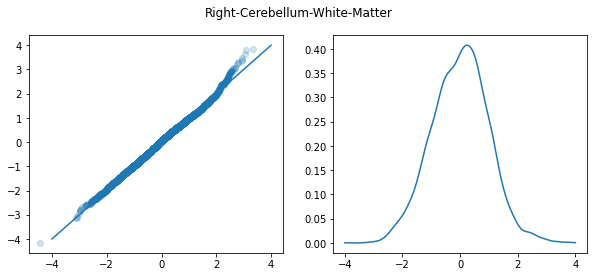

0.0 0.9 -0.07 0.04


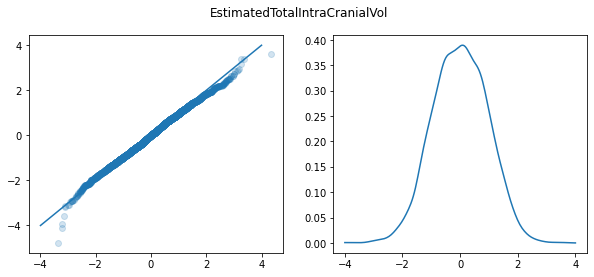

-0.01 1.04 0.19 -0.01


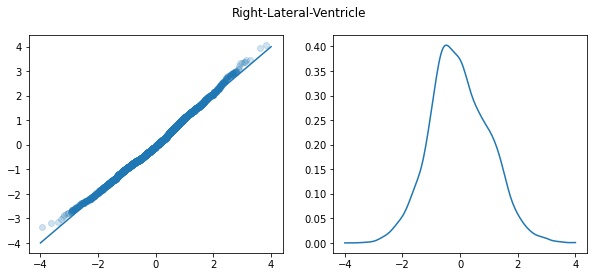

-0.02 1.11 0.98 1.37


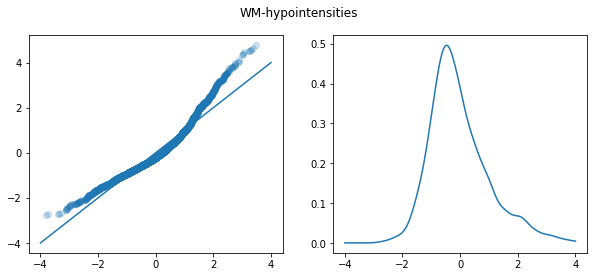

-0.02 0.96 0.03 0.03


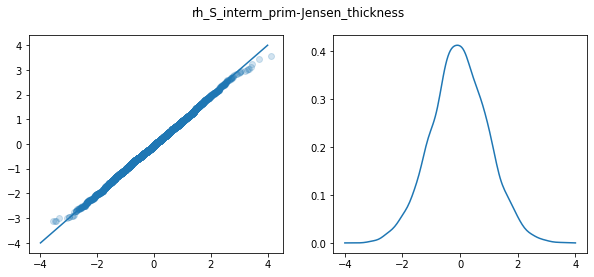

0.0 0.96 -0.15 0.12


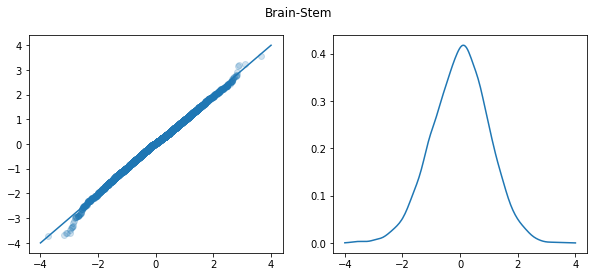

In [89]:
from scipy.stats import skew, kurtosis


for i in range(6):
    z = np.loadtxt(f'/project_cephfs/3022017.02/projects/stijdboe/make_results/10_folds_results/fold_0_blr/batch_{i+1}/Z_estimate.txt')
    print(round(z.mean(),2), round(z.var(),2), round(skew(z),2), round(kurtosis(z),2))
    fig, ax = plt.subplots(1,2, figsize= (10,4))
    ax[0].scatter( np.sort(np.random.randn(*z.shape)),np.sort(z),alpha =0.2)
    ax[0].plot([-4,4],[-4,4])
    
    dens = gaussian_kde(z)
    ran = np.linspace(-4,4,200)
    ax[1].plot(ran, dens(ran))
    plt.suptitle(Y_tr.columns[i])
    plt.show()

In [11]:
moments = np.zeros((10,6,4))
import scipy
for iff, feature in enumerate(Y_tr.columns):
    for f in range(10):
        z = np.loadtxt(f'/project_cephfs/3022017.02/projects/stijdboe/make_results/10_folds_results/fold_{f}_blr/batch_{iff+1}/Z_estimate.txt')
        moments[f,iff,0] = np.mean(z)
        moments[f,iff,1] = np.var(z)
        moments[f,iff,2] = scipy.stats.skew(z)
        moments[f,iff,3] = scipy.stats.kurtosis(z)
    print(feature)
    print(np.round(np.mean(moments[:,iff],axis=0),2))
        

Right-Cerebellum-White-Matter
[-0.    1.    0.06  0.57]
EstimatedTotalIntraCranialVol
[-0.    1.   -0.04  0.71]
Right-Lateral-Ventricle
[-0.    1.    0.32  0.89]
WM-hypointensities
[-0.    1.    0.34  0.52]
rh_S_interm_prim-Jensen_thickness
[-0.    1.    0.03  0.31]
Brain-Stem
[-0.    0.99 -0.    0.51]


In [12]:
print(np.round(moments.mean(axis=0),2))

[[-0.    1.    0.06  0.57]
 [-0.    1.   -0.04  0.71]
 [-0.    1.    0.32  0.89]
 [-0.    1.    0.34  0.52]
 [-0.    1.    0.03  0.31]
 [-0.    0.99 -0.    0.51]]
